Graph 1: Data Distribution for Dirichlet Alpha=0.5


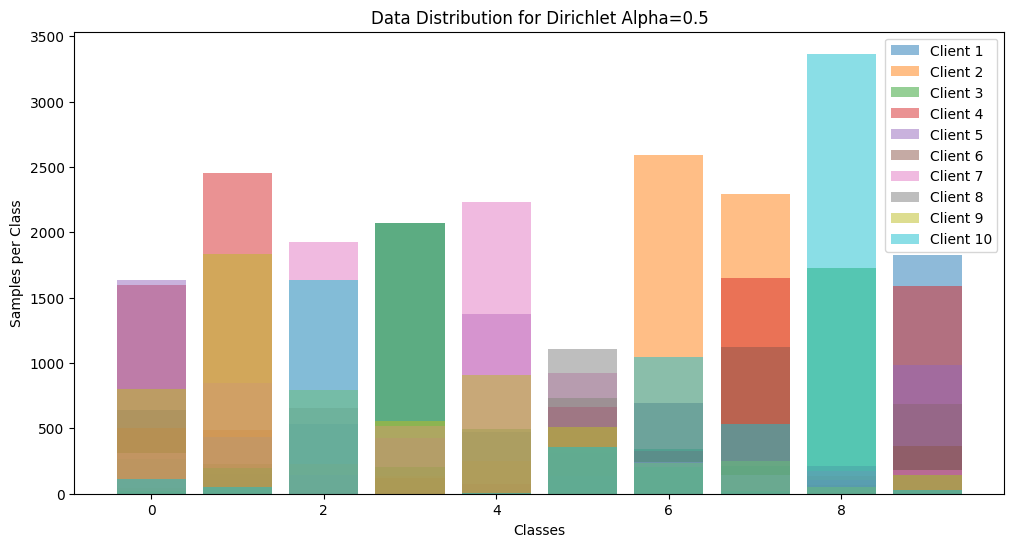

Graph 2: Data Distribution for Dirichlet Alpha=1.0


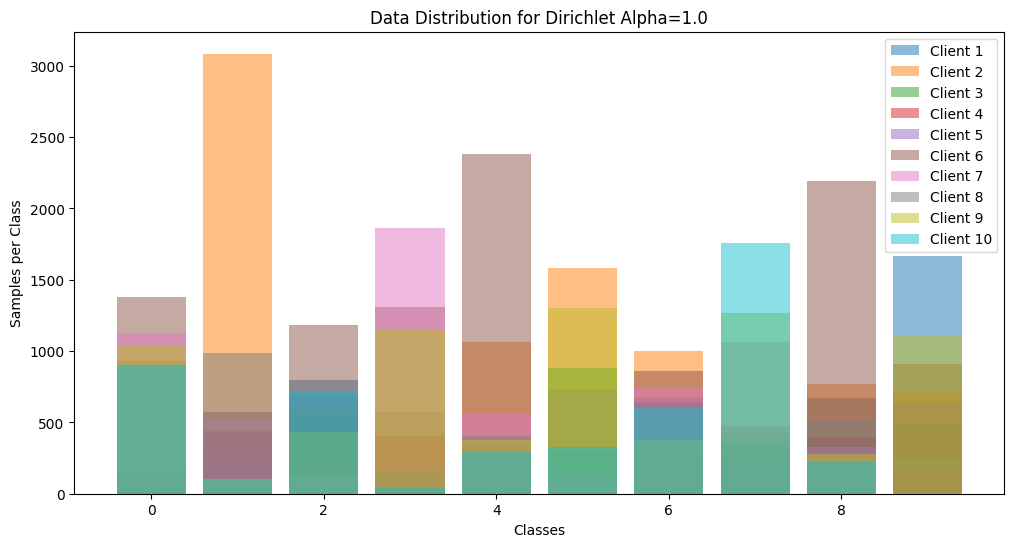

Graph 3: Data Distribution for Dirichlet Alpha=5.0


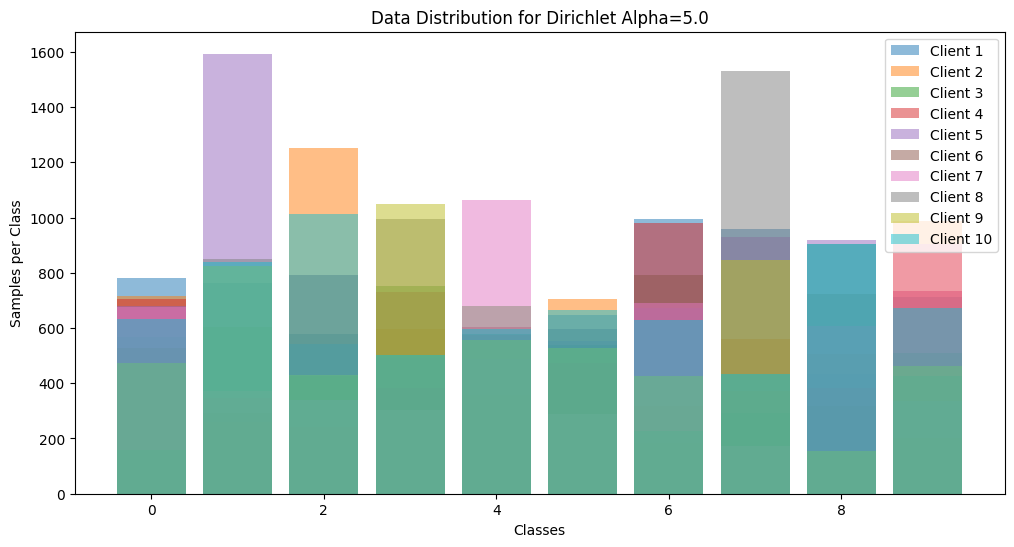

Graph 4: Data Distribution for Dirichlet Alpha=10.0


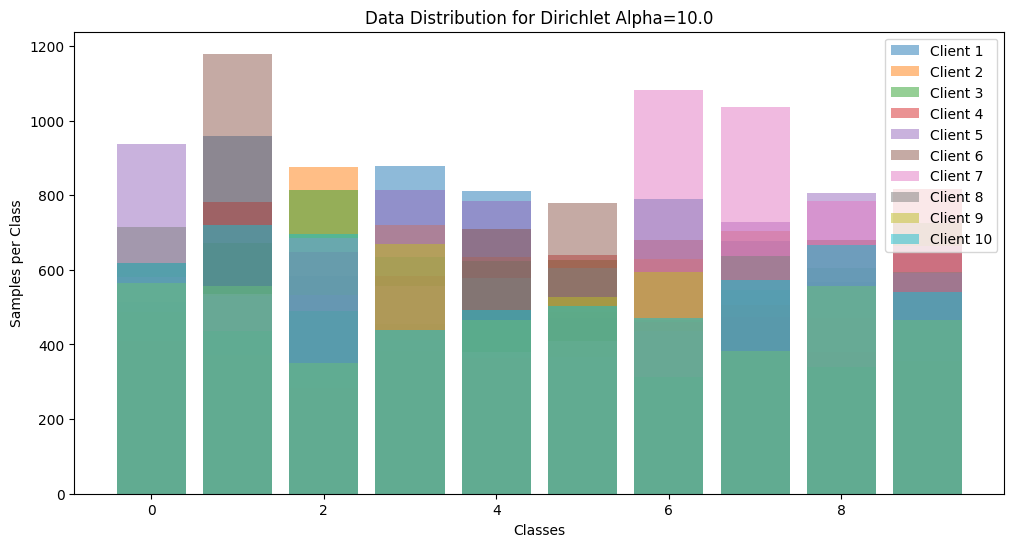

Graph 5: Data Distribution for Dirichlet Alpha=50.0


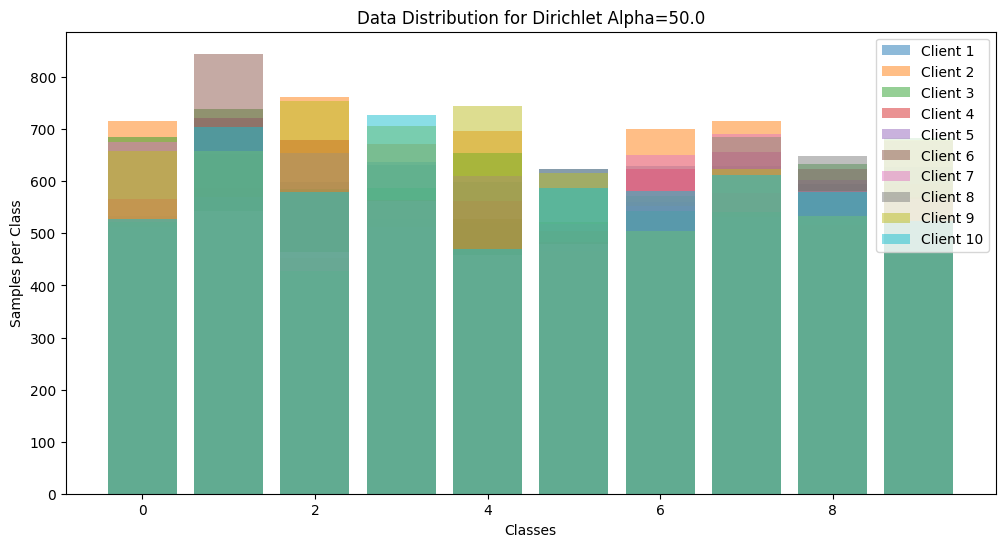

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Parameters
num_clients = 10  # Number of clients
heterogeneity_levels = [0.5, 1.0, 5.0, 10.0, 50.0]  # Dirichlet alpha values
batch_size = 32

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Function to partition data with Dirichlet distribution
def partition_data(train_data, num_clients, alpha):
    labels = np.array(train_data.targets)
    indices = np.arange(len(labels))
    proportions = np.random.dirichlet([alpha] * num_clients, len(np.unique(labels)))

    indices_per_client = [[] for _ in range(num_clients)]
    for label in range(len(proportions)):
        label_indices = indices[labels == label]
        np.random.shuffle(label_indices)
        split_indices = np.cumsum(proportions[label]) * len(label_indices)
        split_indices = split_indices.astype(int)

        for i, (start, end) in enumerate(zip([0] + list(split_indices[:-1]), split_indices)):
            indices_per_client[i].extend(label_indices[start:end])

    return [Subset(train_data, indices) for indices in indices_per_client]

# Visualize Data Distribution
def plot_distribution(client_data_indices, title):
    class_counts = np.zeros((num_clients, 10))  # 10 classes for MNIST
    for client_idx, subset in enumerate(client_data_indices):
        labels = np.array([train_data.targets[i] for i in subset.indices])
        class_counts[client_idx] = np.bincount(labels, minlength=10)
    
    plt.figure(figsize=(12, 6))
    for client_idx in range(num_clients):
        plt.bar(np.arange(10), class_counts[client_idx], alpha=0.5, label=f"Client {client_idx + 1}")
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Samples per Class")
    plt.legend(loc="upper right")
    plt.show()

# Main Execution
for i, alpha in enumerate(heterogeneity_levels):
    client_data_indices = partition_data(train_data, num_clients, alpha)
    title = f"Data Distribution for Dirichlet Alpha={alpha}"
    print(f"Graph {i+1}: {title}")
    plot_distribution(client_data_indices, title)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim

# Parameters
num_clients = 10  # Number of clients
heterogeneity_levels = [0.5, 1.0, 5.0, 10.0, 50.0]  # Dirichlet alpha values
batch_size = 32
epochs = 15
epsilon = 0.03  # FGSM attack strength

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Function to partition data with Dirichlet distribution
def partition_data(train_data, num_clients, alpha):
    labels = np.array(train_data.targets)
    indices = np.arange(len(labels))
    proportions = np.random.dirichlet([alpha] * num_clients, len(np.unique(labels)))

    indices_per_client = [[] for _ in range(num_clients)]
    for label in range(len(proportions)):
        label_indices = indices[labels == label]
        np.random.shuffle(label_indices)
        split_indices = np.cumsum(proportions[label]) * len(label_indices)
        split_indices = split_indices.astype(int)

        for i, (start, end) in enumerate(zip([0] + list(split_indices[:-1]), split_indices)):
            indices_per_client[i].extend(label_indices[start:end])

    return [Subset(train_data, indices) for indices in indices_per_client]

# Simple CNN Model for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Adversarial Attack (FGSM)
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed_images = images + epsilon * images.grad.sign()
    return torch.clamp(perturbed_images, 0, 1)

# Evaluate Model
def evaluate(model, dataloader, attack=None):
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        if attack:
            images = attack(model, images, labels, epsilon)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Main Execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracies = []

for alpha in heterogeneity_levels:
    print(f"Processing Dirichlet Alpha={alpha}")
    client_data_indices = partition_data(train_data, num_clients, alpha)

    # Combine client data for simplicity (can use federated learning here)
    combined_data = torch.utils.data.ConcatDataset(client_data_indices)
    train_loader = DataLoader(combined_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Train the model
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on clean data
    clean_accuracy = evaluate(model, test_loader)
    print(f"Clean Accuracy: {clean_accuracy:.2f}%")

    # Evaluate on adversarial data
    adv_accuracy = evaluate(model, test_loader, attack=fgsm_attack)
    print(f"Adversarial Accuracy: {adv_accuracy:.2f}%")

    accuracies.append((alpha, clean_accuracy, adv_accuracy))

# Plot Results
accuracies = np.array(accuracies)
plt.plot(accuracies[:, 0], accuracies[:, 1], label="Clean Data Accuracy")
plt.plot(accuracies[:, 0], accuracies[:, 2], label="Adversarial Data Accuracy", linestyle="--")
plt.title("Model Accuracy vs Dirichlet Alpha")
plt.xlabel("Dirichlet Alpha")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim

# Parameters
num_clients = 10  # Number of clients
heterogeneity_levels = [0.5, 1.0, 5.0, 10.0, 50.0]  # Dirichlet alpha values
batch_size = 32
epochs = 15
epsilon = 0.03  # FGSM attack strength
attack_iterations = 10  # Iterations for PGD/IFGSM attack
step_size = epsilon / attack_iterations  # Step size for each iteration

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Function to partition data with Dirichlet distribution
def partition_data(train_data, num_clients, alpha):
    labels = np.array(train_data.targets)
    indices = np.arange(len(labels))
    proportions = np.random.dirichlet([alpha] * num_clients, len(np.unique(labels)))

    indices_per_client = [[] for _ in range(num_clients)]
    for label in range(len(proportions)):
        label_indices = indices[labels == label]
        np.random.shuffle(label_indices)
        split_indices = np.cumsum(proportions[label]) * len(label_indices)
        split_indices = split_indices.astype(int)

        for i, (start, end) in enumerate(zip([0] + list(split_indices[:-1]), split_indices)):
            indices_per_client[i].extend(label_indices[start:end])

    return [Subset(train_data, indices) for indices in indices_per_client]

# Simple CNN Model for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Full-Knowledge Adversarial Attack (PGD/IFGSM)
def pgd_attack(model, images, labels, epsilon, alpha, num_iterations):
    perturbed_images = images.clone().detach().requires_grad_(True).to(device)
    
    for _ in range(num_iterations):
        outputs = model(perturbed_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_images = perturbed_images + alpha * perturbed_images.grad.sign()
            # Project back to epsilon-ball
            perturbation = torch.clamp(perturbed_images - images, -epsilon, epsilon)
            perturbed_images = torch.clamp(images + perturbation, 0, 1).detach_()
            perturbed_images.requires_grad_(True)
    
    return perturbed_images

# Evaluate Model
def evaluate(model, dataloader, attack=None):
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        if attack:
            images = attack(model, images, labels, epsilon, step_size, attack_iterations)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Main Execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracies = []

for alpha in heterogeneity_levels:
    print(f"Processing Dirichlet Alpha={alpha}")
    client_data_indices = partition_data(train_data, num_clients, alpha)

    # Combine client data for simplicity (can use federated learning here)
    combined_data = torch.utils.data.ConcatDataset(client_data_indices)
    train_loader = DataLoader(combined_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Train the model
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on clean data
    clean_accuracy = evaluate(model, test_loader)
    print(f"Clean Accuracy: {clean_accuracy:.2f}%")

    # Evaluate on adversarial data
    adv_accuracy = evaluate(model, test_loader, attack=pgd_attack)
    print(f"Adversarial Accuracy: {adv_accuracy:.2f}%")

    accuracies.append((alpha, clean_accuracy, adv_accuracy))

# Plot Results
accuracies = np.array(accuracies)
plt.plot(accuracies[:, 0], accuracies[:, 1], label="Clean Data Accuracy")
plt.plot(accuracies[:, 0], accuracies[:, 2], label="Adversarial Data Accuracy", linestyle="--")
plt.title("Model Accuracy vs Dirichlet Alpha")
plt.xlabel("Dirichlet Alpha")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()
